# Programming Skills Assessment 2
## Part 2 - Performance experiments
By _Miguel Sozinho Ramalho, s2004624_

On the _1st semester, 19/20_

# 1 - Introduction
<!--Short introduction to the rest of the report.-->
The present report performs a performance experiment on the previously developed code for the **percolation** problem. As defined in earlier work, the problem consists of generating a randomly filled grid and then testing if there are paths of empty cells connecting the top of the grid with the bottom of the grid. 

This problem was solved in C and the compiled executable `main.out` (as a result of running the `make` command for the provided `Makefile`) can receive the following parameters:
* `-g` which is the grid size, ie. the number of rows (or columns as it is a square grid) [`default=20`]
* `-s` the value to use for the seed [`default=1564`]
* `-r` the value for `rho` (`[0,1]`) [`default=0.4`]
* `-m` the maximum number of clusters to show, if not present all clusters are displayed
* `-d` the name of the `.dat` file to output the grid to  [`default=map.dat`]
* `-p` the name of the `.pgm` file to output the grid (in a pgm format) to [`default=map.pgm`]

The present report focuses on the performance evolution (measure in terms of execution time of the compiled code) as a function of both the density of filled cells (rho or `-r`) and grid size (`-g`). 

### 1.1 - Report environment
The report is developed as a [Jupyter Notebook](https://jupyter.org/) (using the Python language) which is considered to be a more flexible way of explaining the methodology and results achieved while keeping the formality of a report, when compared to traditional static reports. Moreover, the deliverable for this project is a PDF of the notebook, as per the specification, but the original notebook (`performance_report.ipynb`) and the utilities file (`utils.py`) used for the performance execution can be found in the assignment 2 code submission (for Part 1 - testing) under the `performance` folder.

### 1.2 - Structure
In terms of structure, the following sections are:
 * Method: which goes over the process used for compiling, running and measuring the C code.
 * Results: where relevant plots are created and displayed
 * Discussion: where the previous section results are discussed
 * Conclusion: which is dedicated to a reflection process and proposal of future performance experiments ideas

# 2 - Method
<!-- Description of how you carried out your experiment, what your set up was, how you collected data. -->
This section will do a step-by-step explanation of how the experiment was carried out and in what context it was executed.

### 2.1 - Context
Here are some explicit details of the environment in which the code performance tests were executed:
 * **Machine hardware:**
     * Processor: Intel(R) Core(TM) i5-8625U CPU @ 1.60GHz
     * RAM: 16GB
     * System Type: 64bit OS, x64-based processor
 * **OS:** Windows Subsystem for Linux (from Windows 10)
 * **Software version:** Python 3.6.8
 
 The remaining of the section will describe other relevant details such as _third party tools_ and _data collection techniques_.

### 2.2 - Third party tools
Below are the included third party tools and their purpose.

In [ ]:
# Data handling
import numpy as np

In [94]:
# Data Visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [ ]:
# Experiment execution progress visualization
from tqdm.notebook import tqdm

In [110]:
# Python libraries used for the experiments
import random # generate random seeds to avoid biases to a given seed
random.seed(a=None) # set the seed to the current system time
import resource # to measure the real execution time of the user proce

In [97]:
# user-defines utility functions to execute bash commands from Python
from utils import custom_subprocess, make_project

### 2.3 - Experiment

Initially, we compile the latest version of the code

In [99]:
make_project()

Then, we choose what values to test for both variables under scrutiny: grid size and density (rho)

In [104]:
grids = list(range(0, 201, 10))
print("Using %d different values for grid size:" % len(grids))
print(grids)

Using 21 different values for grid:
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


In [105]:
rhos = list(np.linspace(0, 1, 21))
print("Using %d different values for density:" % len(rhos))
print(rhos)

Using 21 different values for density:
[0.0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003, 0.4, 0.45, 0.5, 0.55, 0.6000000000000001, 0.65, 0.7000000000000001, 0.75, 0.8, 0.8500000000000001, 0.9, 0.9500000000000001, 1.0]


In [107]:
print("Total combinations to explore: %d" % (len(grids) * len(rhos)))

Total combinations to explore: 441


We then define a function `execute_and_time` which receives individual values for `grid` and `rho` and is capable of calling the executable `main.out` with those values as parameters and also includes a randomly generated `seed`.

This function then takes the real usage of the system call, in seconds, and returns it.

In [115]:
def execute_and_time(grid, rho, silent=True):
    # define the parameters to use when calling main.out
    params = ["../code/main.out", "-g %d" % grid, "-r %.10f" % rho, "-s %d" % random.randint(0, 1e4)]
    # measure time at start
    usage_start = resource.getrusage(resource.RUSAGE_CHILDREN).ru_utime
    # execute code
    custom_subprocess(params, silent)
    # measure time at end and return difference
    return resource.getrusage(resource.RUSAGE_CHILDREN).ru_utime - usage_start

After this, we follow to create a list of (`i, j, grid, rho`) for all possible combinations of `grids` and `rhos`. In this list:
 * `i` is the index of the current `grid` value in the `grids` list
 * `j` is the index of the current `rho` value in the `rhos` list

In [120]:
combs = [(i, j, grid, rho) for i, grid in enumerate(grids) for j, rho in enumerate(rhos)]
print("Confirming the number of combinations: %d" % len(combs))
print("first combination: %s" % str(combs[0]))
print("last combination: %s" % str(combs[-1]))

Confirming the number of combinations: 441
first combination: (0, 0, 0, 0.0)
last combination: (20, 20, 200, 1.0)


Now, we create a matrix of dimensions `len(grids)` x `len(rhos)` that will eventually contain the execution times for each pair of combinations.

In [138]:
times = np.zeros((len(grids), len(rhos)), dtype=int).tolist()

Following this, we will now iterate over each of the combinations and fill the `times` matrix cells with the corresponding execution time.

[`tqdm`](https://github.com/tqdm/tqdm) is used to provide a progress bar given that the experiments can run over several minutes.

In [140]:
for i, j, g, r in tqdm(combs):
    times[i][j] = execute_and_time(g, r)

# 3 - Results
<!-- Your results, including a clear graphical presentation of any performance data. -->
Now that we have computed the execution times and saved them in the `times` variable, we can obtain some interesting results from them. 

Firstly, we will plot a 2D countour plot where `rho` is our x-axis, `grid` is our y-axis and the colour describes the execution time for each measure point. Although it is impossible to measure over a continuous value, the values we have are sufficient to trace the countours and identify similar-execution-time areas. This is Figure 1.

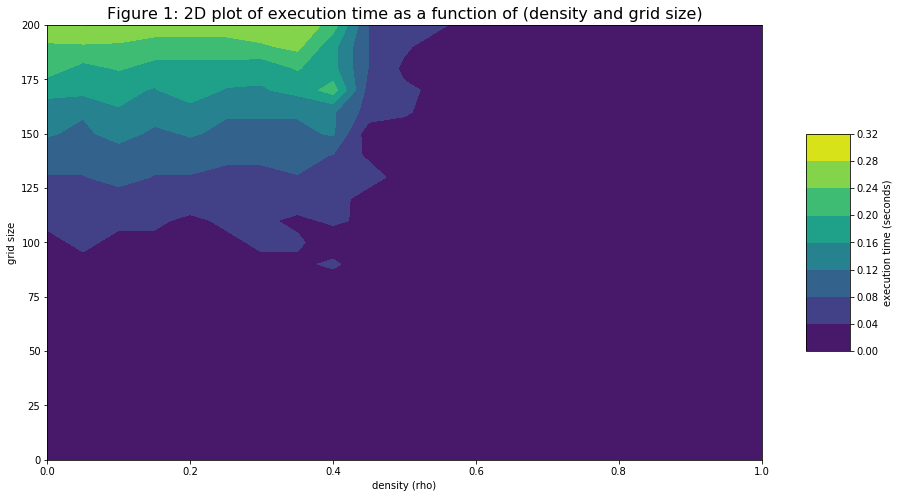

In [141]:
# create the figure with accurate descriptions
plt.figure(figsize=(16, 8))
plt.title("Figure 1: 2D plot of execution time as a function of (density and grid size)", size=16)
plt.xlabel('density (rho)')
plt.ylabel('grid size')
# plot the data
plt.contourf(rhos, grids, times)
# customize the righ side color bar
cb = plt.colorbar(shrink=0.5, aspect=5)
cb.set_label("execution time (seconds)")

Secondly, we are going to visualize the same patterns but in a tri-dimensional manner, where we still have a colour describing the execution time for the combination of parameters but now height also illustrates the execution time. This is Figure 2.

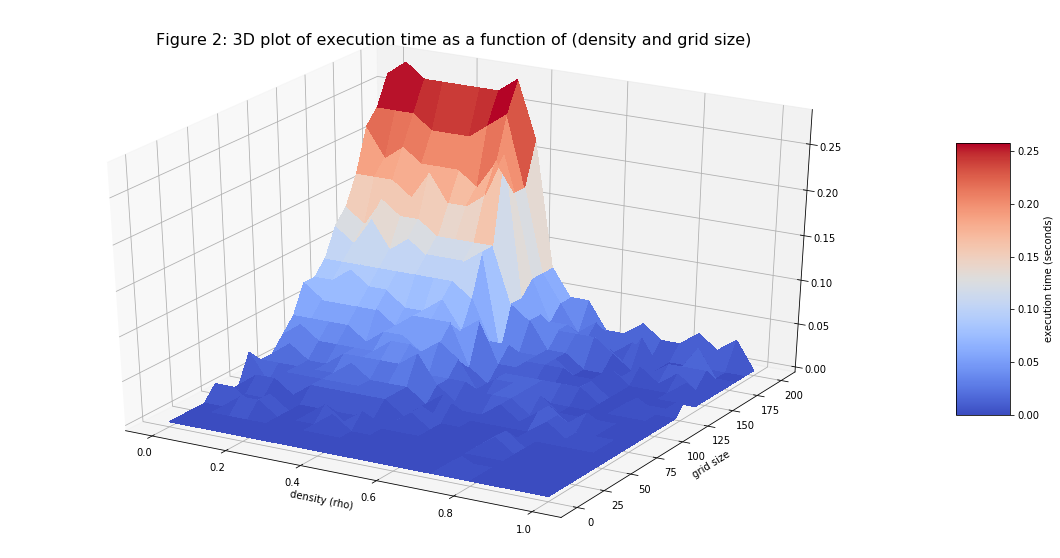

In [144]:
# create the figure with accurate descriptions
fig = plt.figure(figsize=(20, 10))
ax = fig.gca(projection="3d")
ax.set_title("Figure 2: 3D plot of execution time as a function of (density and grid size)", size=16)
plt.xlabel("density (rho)")
plt.ylabel("grid size");
# convert into appropriate format and then plot the data
X, Y = np.meshgrid(np.array(rhos), np.array(grids))
Z = np.array(times)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# customize the righ side color bar
cb = fig.colorbar(surf, shrink=0.5, aspect=5)
cb.set_label("execution time (seconds)")

Thirdly, we are going to project the previous curve in a scatter plot so that we can compare how time execution varies with 

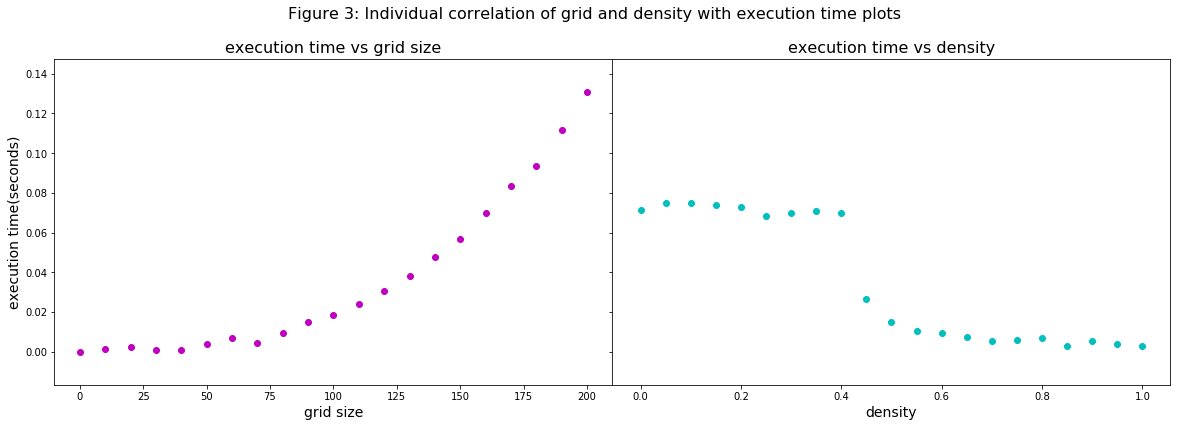

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,6))
fig.subplots_adjust(wspace=0)
# left plot
ax1.scatter(grids, np.mean(times, axis=1), c="m")
ax1.set_ylabel("execution time(seconds)", size=14)
ax1.set_title("execution time vs grid size", size=16)
ax1.set_xlabel("grid size", size=14)
# right plot
ax2.scatter(rhos, np.mean(times, axis=0), c="c")
ax2.set_title("execution time vs density", size=16)
ax2.set_xlabel("density", size=14);
fig.suptitle("Figure 3: Individual correlation of grid and density with execution time plots", fontsize=16, y=1);

# 4 - Discussion
Analysis and discussion of your results.

# 5 - Conclusions
Some brief conclusions and suggestions for future work. 